In [2]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [4]:
graph_builder = StateGraph(State)

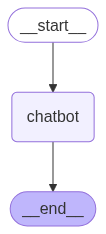

In [5]:
llm = init_chat_model("ollama:llama3.2")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: LangChain is an open-source, Python-based library that enables the creation of conversational AI models using a modular and flexible architecture. It's designed to make it easier for developers to build and train conversational models, such as chatbots and voice assistants.

LangChain was created by Meta AI and is built on top of popular libraries like PyTorch and Transformers. The library provides a set of pre-trained models and a simple API that allows users to integrate these models into their own applications.

Key features of LangChain include:

1. **Conversational flow management**: LangChain helps manage the conversation flow by providing a way to define intents, entities, and dialogue flows.
2. **Contextual understanding**: The library provides tools for contextual understanding, such as context-aware intent detection and entity recognition.
3. **Knowledge graph integration**: LangChain allows users to integrate knowledge graphs into their conversational models, enab

In [8]:
import os

os.environ["TAVILY_API_KEY"] = "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"

In [9]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph?',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. **Nodes**: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by 

In [10]:
llm = init_chat_model("ollama:llama3.2")

In [11]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [12]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [13]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(
            f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

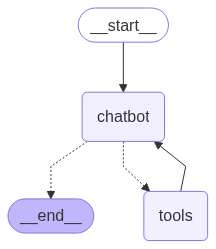

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: {"query": "langgraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.analyticsvidhya.com/blog/2024/07/langgraph-revolutionizing-ai-agent/", "title": "What is LangGraph?", "content": "To sum up, LangGraph is a major advancement in the development of AI agents. It enables developers to push the limits of what\u2019s possible with AI agents by eliminating the shortcomings of earlier systems and offering a flexible, graph-based framework for agent construction and execution. LangGraph is positioned to influence the direction of artificial intelligence significantly in the future. [...] LangGraph is a library built on top of Langchain that is designed to facilitate the creation of cyclic graphs for large language model (LLM) \u2013 based AI agents.\n It views agent Objective Points about LangGraph and workflows as cyclic graph topologies, allowing for more variable and nuanced agent behaviors than linear execution models."

In [16]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

In [17]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: {"query": "langgraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.analyticsvidhya.com/blog/2024/07/langgraph-revolutionizing-ai-agent/", "title": "What is LangGraph?", "content": "To sum up, LangGraph is a major advancement in the development of AI agents. It enables developers to push the limits of what’s possible with AI agents by eliminating the shortcomings of earlier systems and offering a flexible, graph-based framework for agent construction and execution. LangGraph is positioned to influence the direction of artificial intelligence significantly in the future. [...] LangGraph is a library built on top of Langchain that is designed to facilitate the creation of cyclic graphs for large language model (LLM) – based AI agents.\n It views agent Objective Points about LangGraph and workflows as cyclic graph topologies, allowing for more variable and nuanced agent behaviors than linear execution models.", "score":